## 1. Preprocess

Di tahap awal modeling ini, baik data training dan testing di-preprocess terlebih dahulu. EDA akan dilakukan sambil jalan. 

Langkah-langkah preprocessing yang dilakukan cukup minimalis, hanya lowercasing, menghapus angka (baik yang berdiri sendiri dan tergabung dengan alphabetic string), dan menghapus double whitespace.

Setelah melakukan preprocess, data di-tokenize. Saat proses tokenize, sekalian ditambah token \<s\> dan \<e\> masing-masing sebagai penanda awal dan akhir dokumen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
import re
import gensim.models

import torch
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torch.utils.data.dataset import Dataset

In [2]:
# Custom tokenizer

def tokenize(nlp):        
    emo1 = r'''[>O0]?[:;8X=]+[-|^]?["|']?[()|\/\\DoOSvVcCPpb3*>]+'''
    emo2 = r'''<3{1,}'''
    emo3 = r'''[D|d]-?[:|;|=]<?'''
    emo4 = r'''[-+=]_+[-+=]['"]?'''
    url = r'''((www\.[^\s]+)|(https?://[^\s]+))'''
    plur = r'''[A-Za-z]+2+[A-Za-z]*'''

    # Set custom rules of prefixes, suffixes, and infixes
    # prefixes = [r'''\W.+[^.,?!'"`|%]'''] + [r'''[A-Za-z0-9]+[-.,][A-Za-z0-9]+'''] + [r'''https\S+''']
    # prefixes = [r'''[^a-zA-Z\d\s:]'''] + [r'''((www\.[^\s]+)|(https?://[^\s]+))''']
    prefixes = [url] + [emo1] + [emo2] + [emo3] + [emo4] + [plur] + nlp.Defaults.prefixes
    prefix_regex = compile_prefix_regex(prefixes)
    
    suffixes = [emo1] + [emo2] + [emo3] + [emo4] + [plur] + nlp.Defaults.suffixes
    suffix_regex = compile_suffix_regex(suffixes)
    
    infixes = (
        LIST_ELLIPSES
        + LIST_ICONS
        + [
            r"(?<=[0-9])[+\-\*^](?=[0-9-])",
            r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
                al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
            ),
            r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
            # EDIT: commented out regex that splits on hyphens between letters:
            #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
            r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
        ] + [r"^\n"] 
    )

    infix_regex = compile_infix_regex(infixes)

    
    return Tokenizer(nlp.vocab, prefix_search=prefix_regex.search,
                                suffix_search=suffix_regex.search,
                                infix_finditer=infix_regex.finditer,
                                token_match=None)

In [3]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('[\s]+', ' ', text)
    
    return text

nlp = spacy.blank('id')
nlp.tokenizer = tokenize(nlp)    

def tokenize_wrap(df_series):    
    docs = nlp.tokenizer.pipe(df_series)
    tokens_list = list()
    for doc in docs:
        tokens = [token.text for token in doc]
        tokens.insert(0, '<s>')
        tokens.append('<e>')
        tokens_list.append(tokens)
        
    return pd.Series(tokens_list)

In [4]:
#Read data

train = pd.read_csv('train_data_restaurant.tsv', delimiter='\t', names=['text', 'label'])
test = pd.read_csv('test_data_restaurant.tsv', delimiter='\t', names=['text', 'label'])

In [5]:
train['cleaned'] = train['text'].apply(lambda x: preprocess(x))
train['tokenized'] = tokenize_wrap(train['cleaned'])

test['cleaned'] = test['text'].apply(lambda x: preprocess(x))
test['tokenized'] = tokenize_wrap(test['cleaned'])

In [6]:
train[['text', 'label']].groupby('label').agg('count')

text
label         
negative   580
positive  1200

In [7]:
test[['text', 'label']].groupby('label').agg('count')

text
label         
negative    65
positive   120

In [8]:
print('Longest length of review in train set: ', train['tokenized'].map(len).max())
print('Longest length of review in test set: ', test['tokenized'].map(len).max())

Longest length of review in train set:  85
Longest length of review in test set:  78


## 2. Train word2vec

Selanjutnya, data digunakan untuk membangun word2vec yang akan digunakan sebagai input di model deep learning. Model word2vec yang dipilih ada Skip-gram dengan hirearchical softmax. Dimensi embedding yang dipilih adalah 200.

Paper rujukan:
> Nawangsari, R. P., Kusumaningrum, R., & Wibowo, A. (2019). Word2Vec for Indonesian sentiment analysis towards hotel reviews: An evaluation study. Procedia Computer Science, 157, 360-366. https://doi.org/10.1016/j.procs.2019.08.178


In [9]:
#Add padding token
corpus = train['tokenized'].tolist()
corpus.append(['<pad>'])

In [10]:
model = gensim.models.Word2Vec(sentences=corpus, min_count=1, sg=1, hs=1, size=200)
# output_model = 'model/' + 'w2v.txt' #so we can use this later for improvement

#Digunakan untuk transform input di PyTorch
model_vec = model.wv
model_vec.save('w2v-vectors.kv')

del model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## 3. Define Dataset class

Pada tahap ini, kita define sebuah custom class Dataset untuk batching data ketika training model. Di dalam class ini, sekalian setiap dokumen di-padding untuk menyamakan panjang inputan. Panjang inputan disamakan menjadi 100 sequence melihat review paling panjang adalah 85 kata (termasuk token <s\> dan <e\>).
 Disertakan juga metode dropout ketika padding dokumen dengan cara randomly assign token 0 (stands for unknown). Ini dilakukan untuk membantu model generalizing dengan jumlah training set yang sedikit serta kelas yang imbalace.



In [11]:
class TensorData(Dataset):
    def __init__(self, X, y, dropout=0):
        self.X = X
        self.y = y
        self.dropout = dropout
        self.w2v = gensim.models.KeyedVectors.load('w2v-vectors.kv')
        self.max_len = 100
        self.padding_idx = self.w2v.vocab['<pad>'].index
        self.evaluate = False

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        padded = [self.padding_idx for i in range(self.max_len)]
        
        if self.evaluate == True:
          for i, token in enumerate(self.X[idx]):
              drop = np.random.rand()
              if drop > self.dropout and token in self.w2v.vocab:
                  padded[i] = self.w2v.vocab[token].index
              else:
                  padded[i] = 0
        elif self.evaluate == False:
          for i, token in enumerate(self.X[idx]):
            if token not in self.w2v.vocab:
              padded[i] == 0
            else:
              padded[i] = self.w2v.vocab[token].index
        
        data_text = torch.tensor(padded, device=device)
        
        if self.y[idx] == 'positive':
            data_label = 1
            
        elif self.y[idx] == 'negative':
            data_label = 0
            
        return data_text, data_label

    def eval(self):
      self.evaluate = True
    
    def train(self):
        self.evaluate = False

## 4. Define model

Model yang digunakan dalam eksperimen ini adalah sebuah model LSTM sederhana. LSTM dikenal memiliki performa yang baik untuk general text classification.

In [12]:
class LSTM(nn.Module):
    def __init__(self, output_size, batch_size, hidden_dim, n_layers, drop_prob=0.5):
    
        super().__init__()
        
        self.embedding_dim = 200
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        w2v = gensim.models.KeyedVectors.load('w2v-vectors.kv')
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v.wv.vectors),
                                                      padding_idx=w2v.vocab['<pad>'].index)
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, n_layers, batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
                

    def forward(self, X):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        embeds = self.embedding(X)
        outputs, h = self.lstm(embeds)
        output = self.dropout(outputs)        
        output = output.contiguous().view(-1, self.hidden_dim)
        output = self.fc(output)
        output = self.sigmoid(output)
        output = output.view(self.batch_size, -1)
        output = output[:, -1]   

        return output

    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

## 5. Training & Testing



In [13]:
#Function to split training set indices to training and validation

def data_split(dataset, val_percent=0.2):
  train_val_size = len(dataset)
  train_val_indices = list(range(train_val_size))
  np.random.shuffle(train_val_indices)
  
  val_split_index = int(np.floor(val_percent * train_val_size))
  train_idx, val_idx = train_val_indices[val_split_index:], train_val_indices[:val_split_index]

  return train_idx, val_idx

In [14]:
#Functions used in training loop

def train_model(model, x, y, criterion, optimizer):
    
    model.train()
    model.zero_grad()
    y_pred = model(x)
    y = y.squeeze()
    # y = y.unsqueeze(1)
    loss = criterion(y_pred, y.float())
    loss.backward()
    optimizer.step()
    
    return loss.item()


def validate(model, x_valid, y_valid, criterion):

    model.eval()
    y_pred = model(x_valid)
    y_valid = y_valid.squeeze()
    # y_valid = y_valid.unsqueeze(1)
      
    loss = criterion(y_pred, y_valid.float())
    
    return loss.item()

In [51]:
#Function to wrap the whole training loop

def training(n_epoch, model, tval_set, testloader, trainloader, valloader, lr):
  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  loss_train = []
  loss_valid = []

  for epoch in range(n_epoch):
      
      tval_set.train()
      training_loss = 0.0
      for inputs, labels in trainloader:
          inputs, labels = inputs.to(device), labels.to(device)  
          t_loss = train_model(model=model, x=inputs, y=labels, criterion=criterion, optimizer=optimizer)
          training_loss += t_loss
          
      t = training_loss / len(trainloader)
      loss_train.append(t)

      if epoch % 10 == 0:
        tval_set.eval()
        valid_loss = 0.0
        for val_inputs, val_labels in valloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            v_loss = validate(model=model, x_valid=val_inputs, y_valid=val_labels, criterion=criterion)
            valid_loss += v_loss
        
        v = valid_loss / len(valloader)
        loss_valid.append(v)
        print('Epoch checkpoint: ', epoch)
        print('Train loss: {:.4f}'.format(t))
        print('Valid loss: {:.4f}'.format(v))

  return loss_train, loss_valid

In [16]:
#Testing

def test_evaluation(model, testloader):
  criterion = nn.BCEWithLogitsLoss()

  model.eval()
  loss_test = list()
  num_correct = 0

  for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)
      test_outputs = model(inputs)
      labels.squeeze()
      tloss = criterion(test_outputs, labels.float())
      loss_test.append(tloss.item())
      pred = torch.round(test_outputs.squeeze())  # Rounds the output to 0/1
      correct_tensor = pred.eq(labels.float().view_as(pred))
      correct = np.squeeze(correct_tensor.cpu().numpy())
      num_correct += np.sum(correct)

  print("Test loss: {:.3f}".format(np.mean(loss_test)))
  test_acc = num_correct/len(testloader.dataset)
  print("Test accuracy: {:.3f}%".format(test_acc*100))

In [17]:
#Plot loss

def plot_loss(valid_loss, train_loss):
  r_train = range(len(train_loss))
  r_valid = range(0, len(train_loss), 10)

  fig, ax = plt.subplots()
  ax.plot(r_valid, valid_loss, label='Valid', color='orange')
  ax.plot(r_train, train_loss, label='Train', color = 'blue')
  plt.title('Train - Validation loss')
  plt.legend(['Validatioin', 'Training'])
  
  return plt.show()

### a. Trial pertama

Untuk percobaan pertama menggunakan ukuran network yang kecil dan regularisasi yang tidak berlebihan untuk mengecek tren learning dari model LSTM ini.

In [18]:
torch.manual_seed(6)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [70]:
BATCH_SIZE = 5
EPOCHS = 100
DROPOUT_DATA = 0
DROP_PROB = 0.1
LR = 0.0001

N_LAYERS = 1
HIDDEN_DIM = 50
OUTPUT_SIZE = 1

In [71]:
train_indices1, val_indices1 = data_split(dataset=train, val_percent=0.2)
print('Train set length: ', len(train_indices1))
print('Validation set length: ', len(val_indices1))

train_sampler = SubsetRandomSampler(train_indices1)
val_sampler = SubsetRandomSampler(val_indices1)


train_val_set1 = TensorData(train['tokenized'].tolist(), train['label'].tolist(), dropout=DROPOUT_DATA)
val_loader1 = DataLoader(train_val_set1, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=True)
train_loader1 = DataLoader(train_val_set1, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)

test_set1 = TensorData(test['tokenized'].tolist(), test['label'].tolist(), dropout=DROPOUT_DATA)
test_loader1 = DataLoader(test_set1, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Train set length:  1424
Validation set length:  356


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [72]:
net = LSTM(output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, drop_prob=DROP_PROB)
net.to(device)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


LSTM(
  (embedding): Embedding(6878, 200, padding_idx=6877)
  (lstm): LSTM(200, 50, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [73]:
train2, valid2 = training(model=net, n_epoch=EPOCHS, 
                          tval_set=train_val_set1,
                          testloader=test_loader1,
                          trainloader=train_loader1,
                          valloader=val_loader1, lr=LR)

Epoch checkpoint:  0
Train loss: 0.6416
Valid loss: 0.6229
Epoch checkpoint:  10
Train loss: 0.6224
Valid loss: 0.5901
Epoch checkpoint:  20
Train loss: 0.5966
Valid loss: 0.5595
Epoch checkpoint:  30
Train loss: 0.5982
Valid loss: 0.5680
Epoch checkpoint:  40
Train loss: 0.5949
Valid loss: 0.5744
Epoch checkpoint:  50
Train loss: 0.6020
Valid loss: 0.5743
Epoch checkpoint:  60
Train loss: 0.6458
Valid loss: 0.6235
Epoch checkpoint:  70
Train loss: 0.6133
Valid loss: 0.5838
Epoch checkpoint:  80
Train loss: 0.5929
Valid loss: 0.5660
Epoch checkpoint:  90
Train loss: 0.5678
Valid loss: 0.5560


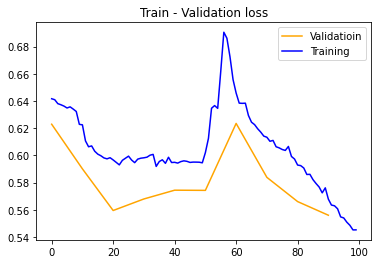

In [74]:
plot_loss(valid_loss=valid2, train_loss=train2)

In [75]:
test_evaluation(model=net, testloader=test_loader1)

Test loss: 0.568
Test accuracy: 74.054%


### b. Trial kedua

In [89]:
BATCH_SIZE = 10
EPOCHS = 150
DROPOUT_DATA = 0.4
DROP_PROB = 0.5
LR = 0.0001

N_LAYERS = 1
HIDDEN_DIM = 150
OUTPUT_SIZE = 1

In [90]:
train_indices, val_indices = data_split(dataset=train, val_percent=0.2)
print('Train set length: ', len(train_indices))
print('Validation set length: ', len(val_indices))

train_val_set = TensorData(train['tokenized'].tolist(), train['label'].tolist(), dropout=DROPOUT_DATA)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(train_val_set, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=True)
train_loader = DataLoader(train_val_set, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)

test_set = TensorData(test['tokenized'].tolist(), test['label'].tolist(), dropout=DROPOUT_DATA)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Train set length:  1424
Validation set length:  356


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [91]:
net_sec = LSTM(output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, drop_prob=DROP_PROB)
net_sec.to(device)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


LSTM(
  (embedding): Embedding(6878, 200, padding_idx=6877)
  (lstm): LSTM(200, 150, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=150, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [92]:
train1, valid1 = training(model=net_sec, n_epoch=EPOCHS, 
                          tval_set=train_val_set,
                          testloader=test_loader,
                          trainloader=train_loader,
                          valloader=val_loader, lr=LR)

Epoch checkpoint:  0
Train loss: 0.6411
Valid loss: 0.6154
Epoch checkpoint:  10
Train loss: 0.6321
Valid loss: 0.5902
Epoch checkpoint:  20
Train loss: 0.5589
Valid loss: 0.5610
Epoch checkpoint:  30
Train loss: 0.6380
Valid loss: 0.5914
Epoch checkpoint:  40
Train loss: 0.6359
Valid loss: 0.6055
Epoch checkpoint:  50
Train loss: 0.6383
Valid loss: 0.5816
Epoch checkpoint:  60
Train loss: 0.5989
Valid loss: 0.6050
Epoch checkpoint:  70
Train loss: 0.6084
Valid loss: 0.5671
Epoch checkpoint:  80
Train loss: 0.6495
Valid loss: 0.5961
Epoch checkpoint:  90
Train loss: 0.6320
Valid loss: 0.6000
Epoch checkpoint:  100
Train loss: 0.6308
Valid loss: 0.5984
Epoch checkpoint:  110
Train loss: 0.5874
Valid loss: 0.5773
Epoch checkpoint:  120
Train loss: 0.6388
Valid loss: 0.6016
Epoch checkpoint:  130
Train loss: 0.6389
Valid loss: 0.6020
Epoch checkpoint:  140
Train loss: 0.6392
Valid loss: 0.6018


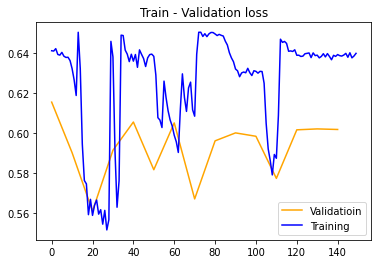

In [93]:
plot_loss(train_loss=train1, valid_loss=valid1)

In [94]:
test_evaluation(model=net_sec, testloader=test_loader)

Test loss: 0.648
Test accuracy: 63.243%


In [131]:
import dill as dill

torch.save(net.state_dict(), 'lstm-dict-1.pt', pickle_module=dill)
torch.save(net_sec.state_dict(), 'lstm-dict-2.pt', pickle_module=dill)

## 6. Predict unseen text

Untuk kebutuhan demo, disediakan fungsi predict yang menerima sebuah review dan menglasifikasikannya.

Ketika melakukan predict, make sure notebook cell yang berisikan import library, fungsi preprocess, dan kelas LSTM di-run terlebih dahulu.

In [123]:
def predict(model, text, seq_len):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  text = preprocess(text)
  doc = nlp.tokenizer.pipe(text)

  tokens = [d.text for d in doc]

  if len(tokens) == 0:
      "Review minimal terdiri dari 1 kata"
      return None

  tokens.insert(0, '<s>')
  tokens.append('<e>')

  w2v = gensim.models.KeyedVectors.load('w2v-vectors.kv')
  pad_idx = w2v.vocab['<pad>'].index
  padded = [pad_idx for i in range(seq_len)]
  
  for i, token in enumerate(tokens):
    if token not in w2v.vocab:
      padded[i] = 0
    else:
      padded[i] = w2v.vocab[token].index

  txt = torch.tensor(padded, device=device)
  model.to(device)
  model.eval()

  txt = txt.unsqueeze(1)
  output = model(txt)
  pred = output.squeeze()

  msg = "Review: positive: {:.3f}".format(pred[0]) if pred[0] > 0.5 else "Review: negative: {:.3f}".format(pred[0])

  return msg

In [132]:
model1 = LSTM(output_size=1, batch_size=5, hidden_dim=50, n_layers=1, drop_prob=0.1)
model1.load_state_dict(torch.load('lstm-dict-1.pt'))

model2 = LSTM(output_size=1, batch_size=10, hidden_dim=150, n_layers=1, drop_prob=0.5)
model2.load_state_dict(torch.load('lstm-dict-2.pt'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


<All keys matched successfully>

In [136]:
review = "Sebetulnya enak sih tempatnya tp yg jaga agak nyebai gmn gitu wkwk"
review2 = 'Kurang suka sama tempat dan pelayanannya. Bisa jadi enak makanannya tapi dah kadung ilfeel duluan'
review3 = 'Gak enak rasa makanannya'

predict(model=model2, text=review, seq_len=100)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


'Review: positive: 0.550'

# Kesimpulan

Sebelumnya, walau tidak ditampilkan semua hasil run-nya , LSTM dicoba di-instaciate menggunakan output softmax dengan parameter yang cukup besar valuenya. LSTM dengan layer softmax menghasilkan rasio training dan validating yang terlalu beragam. Dicoba juga menggunakan LogSoftmax, tetapi justru malah menghasilkan network yang sama sekali tidak belajar dan cukup lama untuk didebug.

Run pertama, menggunakan asumsi karena datasetnya kecil maka ukuran network juga tidak perlu terlalu besar. Hasilnya, tren grafik lossnya cenderung turun dan sepertinya bisa dimaksimalkan dengan jumlah epoch yang lebih tinggi. 

Run kedua, dicoba menggunakan dimensi network yang lebih besar serta parameternya ditingkatkan. Hasilnya, training loss dan validation loss oscalliating karena pilihan learning rate yang sedikit lebih besar daripada trial pertama.

Jika ingin mengembangkan model ini lebih jauh, parameter model pertama lebih layak untuk dikulik lebih lanjut. Teknik-teknik augmentasi data, advanced sampling technique untuk menanggulangi class imbalance serta grid search untuk hyperparameter juga bisa dicoba tapi sayangnya eksperimen ini terbatas waktu dan tenaga komputasi yang dimiliki.